In [1]:
import astropy.io.fits
import astropy.coordinates as coord
import astropy.time as at
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.insert(0,'..')

<h1>20 - Simulating Real Data from EXPRES </h1>
Now let's read in some real data. Simulate under the same conditions and compare our results.

In [2]:
import glob
files = glob.glob('../../wobble_jax/data/101501_spectra/101501_190210.*.fits')

In [3]:
print(files)

['../../wobble_jax/data/101501_spectra/101501_190210.1141.fits', '../../wobble_jax/data/101501_spectra/101501_190210.1154.fits', '../../wobble_jax/data/101501_spectra/101501_190210.1155.fits', '../../wobble_jax/data/101501_spectra/101501_190210.1153.fits']


In [4]:
datas = []
for file in files:
    datas.append(astropy.io.fits.open(file))

In [5]:
data = astropy.io.fits.open('../../wobble_jax/data/101501_spectra/101501_190210.1153.fits')

In [6]:
data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               799922 / length of dimension 1                          
NAXIS2  =                   86 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   17 / number of table fields                         
EXTNAME = 'optimal '           / Extraction algorithm                           
DATE-EXT= '2020-05-27T21:01:06.246' / Date and time of extraction               
EXT_SIZE=                   33 / Size of the extraction window (pixels)         
SCATLGHT=                    T / Scattered light removed before extraction      
PXOFFSET=              -3959

In [7]:
tbl1 = data[0].data

In [8]:
tbl1.shape

(86, 7920)

In [9]:
wav_tbl = data[1].data['wavelength']

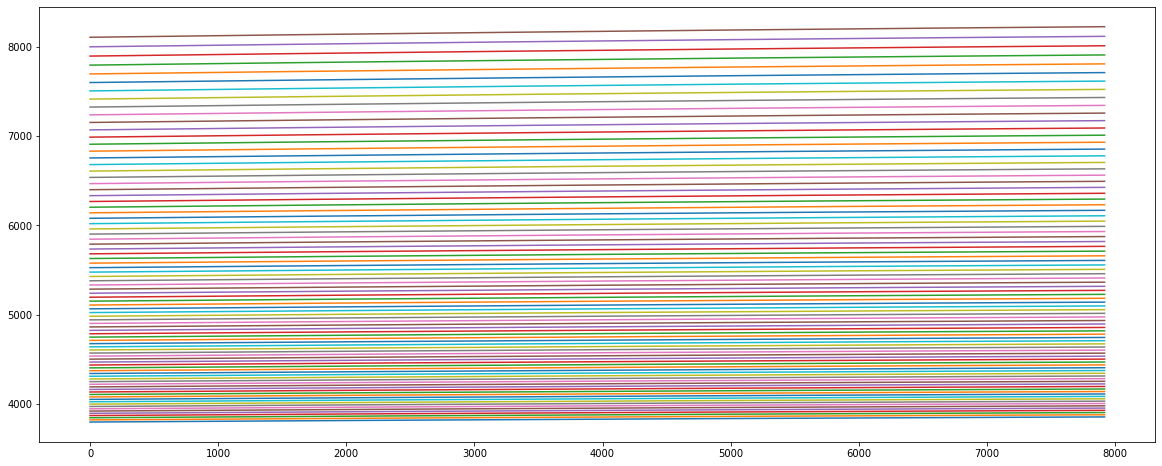

In [10]:
wav_tbl.shape
plt.figure(figsize=(20,8))
for i in range(wav_tbl.shape[0]):
    plt.plot(wav_tbl[i,:])
plt.show()

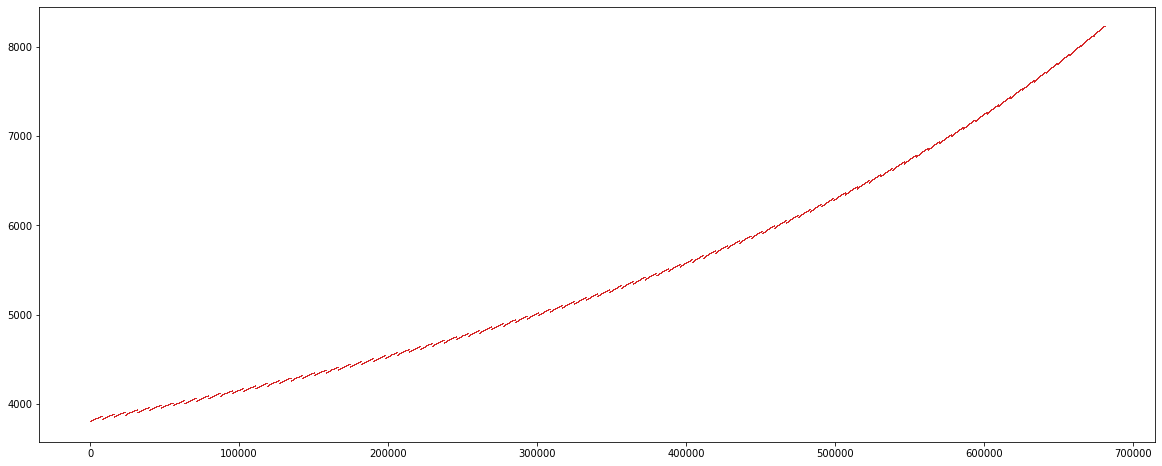

In [11]:
plt.figure(figsize=(20,8))
for data_ele in datas:
    wav = data_ele[1].data['wavelength']
    plt.plot(wav.flatten(),',')
plt.show()

In [12]:
import numpy as np

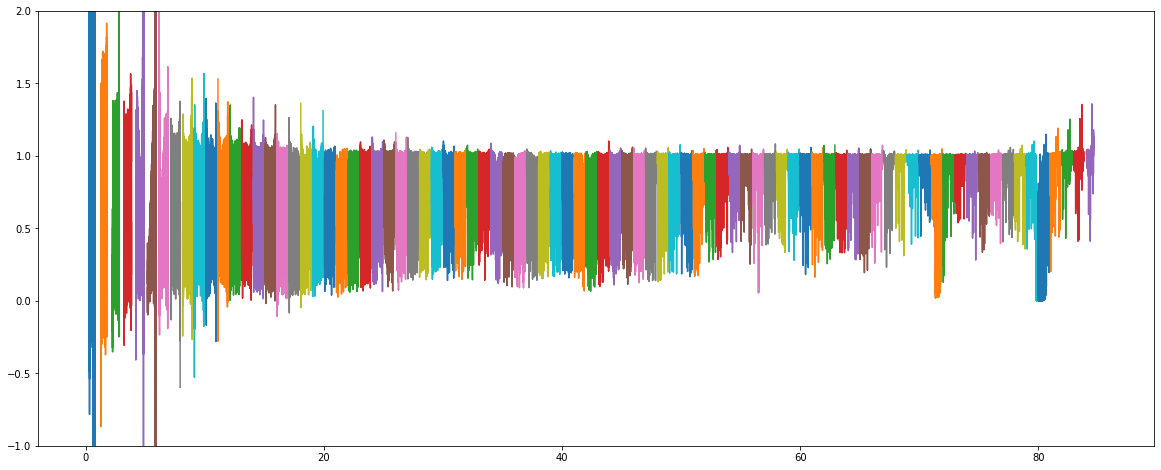

In [13]:
plt.figure(figsize=(20,8))
for i in range(tbl1.shape[0]):
    plt.ylim(-1,2)
    xs = np.linspace(i,i+1,tbl1.shape[1])
    plt.plot(xs,tbl1[i,:])
plt.show()

In [14]:
tbl1 = data[1].data

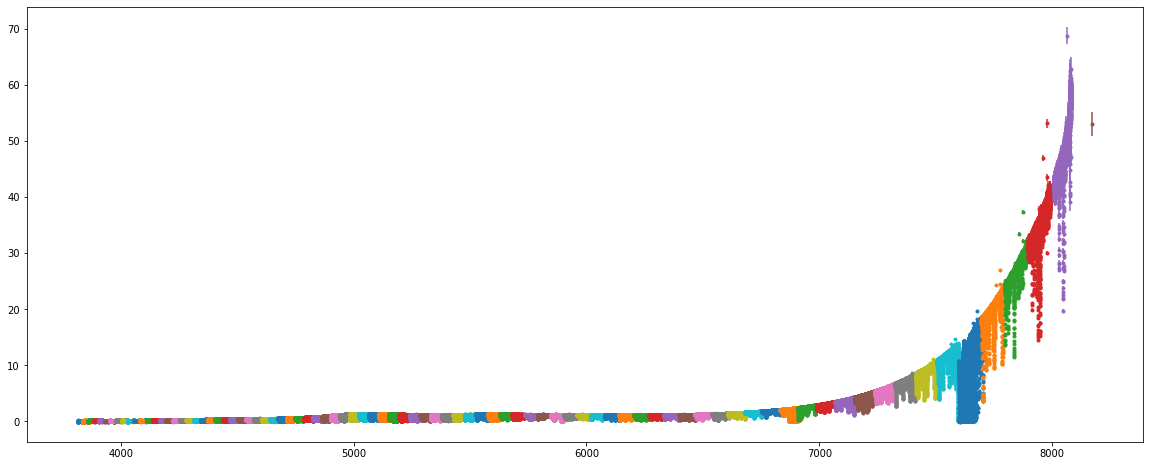

In [15]:
orders = wav_tbl.shape[0]
plt.figure(figsize=(20,8))
for i in range(orders):
    plt.errorbar(tbl1['wavelength'][i,:],tbl1['spectrum'][i,:],yerr=tbl1['uncertainty'][i,:],fmt='.')
# plt.xlim(3820,3825)
plt.show()

In [16]:
from datetime import datetime
import os
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('out/',date)
os.makedirs(outdir,exist_ok=True)

In [17]:
import simulacra.detector
det_dict = simulacra.detector.expres_dict

In [18]:
time_open  = at.Time(data[0].header['DATE-SHT'])
time_close = at.Time(data[0].header['DATE-END'])
time_mid   = (time_close - time_open)/2 + time_open

mjd = at.Time(data[0].header['DATE-OBS'])

In [19]:
exp_time = float(data[0].header['AEXPTIME']) * u.second

In [20]:
ra, dec = coord.Angle(data[0].header['RA'] + ' degrees'), coord.Angle(data[0].header['DEC'] + ' degrees')

In [21]:
loc1 = coord.EarthLocation.from_geodetic(data[0].header['SITELONG'],data[0].header['SITELAT'],data[0].header['SITEELEV'])
target1 = coord.SkyCoord(ra,dec)

In [22]:
true_airmass = data[0].header['AIRMASS']

In [23]:
mjd

<Time object: scale='utc' format='iso' value=2019-02-10 11:43:43.000>

In [24]:
frame1 = coord.AltAz(obstime=mjd + 7/24,location=loc1)
airmass1 = target1.transform_to(frame1).secz

In [25]:
print(true_airmass,airmass1)

1.1012941722399 1.5597328750295747


<h2>Finding nearest phoenix model to data</h2>
First, lets define the grid of models that exist on the phoenix ftp server.

In [26]:
def find_nearest(array,value):
    array = np.asarray(array)
    idx   = (np.abs(array-value)).argmin()
    print('rounding {} -> {} on the grid'.format(value,array[idx]))
    return array[idx]

In [27]:
phx_teff = np.concatenate((np.arange(2300,7000,100),np.arange(7000,12000,200)))
phx_logg = np.arange(0.0,6.0,0.5)
phx_iron = np.concatenate((np.arange(-4.0,-2.0,1.0),np.arange(-2.0,1.0,0.5)))
phx_alfa = np.arange(-0.2,1.2,0.2)

In [28]:
from simulacra.star import PhoenixModel

class Star(PhoenixModel):
    def __init__(self,distance,alpha,z,temperature,logg,target,rv,outdir=None):
        super(PhoenixModel,self).__init__()
        if outdir is None:
            self.outdir = os.path.join('..','data','stellar','PHOENIX')
            os.makedirs(self.outdir,exist_ok=True)
        self.temperature = find_nearest(phx_teff,temperature)
        self.z     = find_nearest(phx_iron,z)
        self.logg  = find_nearest(phx_logg,logg)
        self.alpha = find_nearest(phx_alfa,alpha)
        print(z,self.z)
        print('Z{:+.1f}'.format(self.z))
        self.wavename = simulacra.star.download_phoenix_wave(self.outdir)
        self.fluxname = simulacra.star.download_phoenix_model(self,self.outdir)

        grid = astropy.io.fits.open(self.fluxname)
        self.stellar_radius = grid['PRIMARY'].header['PHXREFF'] * u.cm
        self.surface_flux = grid['PRIMARY'].data * u.erg / u.cm**3 / u.s
        self.wave     = simulacra.star.read_in_fits(self.wavename) * u.Angstrom

        # make these attributes of the phoenix model
        self.distance  = coord.Distance(distance)
        self.target    = target
        self.rv = rv
    
    def get_velocity(self,detector,time):
        return self.rv * np.ones(len(time))

In [29]:
from simulacra.tellurics import TelFitModel

class Tellurics(TelFitModel):
    def __init__(self,airmass,*args):
        super(Tellurics,self).__init__(*args)
        self.secz = airmass
    
    def airmass(self,*args):
        
        return self.secz

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [30]:
distance = 9.541 * u.pc
rv = -5.6 * u.km/u.s
logg = 4.52
T    = 5502

z    = -0.04
alpha= -1.0
rv = 5.6 * u.km/u.s

target = coord.SkyCoord.from_name(name='HD 101501',frame='icrs')
stellar_model = Star(distance,alpha,z,T,logg,target,rv)
detector = simulacra.detector.Detector(stellar_model,**simulacra.detector.expres_dict)

tellurics_model = Tellurics([float(true_airmass)],loc1)
detector.add_model(tellurics_model)

rounding 5502 -> 5500 on the grid
rounding -0.04 -> 0.0 on the grid
rounding 4.52 -> 4.5 on the grid
rounding -1.0 -> -0.2 on the grid
-0.04 0.0
Z+0.0
using saved wave file
../data/stellar/PHOENIX/lte05500-4.50-0.0.Alpha=-0.20.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in ../data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


In [31]:
print(loc1.lat)
print(type(loc1))

34d44m39.498s
<class 'astropy.coordinates.earth.EarthLocation'>


In [ ]:
snr= 250
data = detector.simulate(np.array([mjd]),snrs=snr)

surface flux: mean 2.94e+14 erg / (cm3 s)	 median 2.33e+14 erg / (cm3 s)
obs     flux: mean 1.29e-03 erg / (cm3 s)	 median 1.03e-03 erg / (cm3 s)


resetting...


generating spectra...
humidity: 50.0
 pressure: 10000.0
 temperature: 300.0
 lat: 34.744305000000004
 elevation: 2.336999999999264
 freqmin(cm-1): 10520.79088298197
 freqmax(cm-1): 14295.92566118656
 angle: 24.76649571628065

1282405
<__main__.Tellurics object at 0x7fcb724e1f28> [1.6178939059585673e-06, 2.387303492668025e-07]
interpolating spline...
(1, 1284383)
(1, 1284383)
combining grids...
convolving...
0
xs: 6994.999999999997 9504.986651463456
xhat: 6999.999999999999 9499.988846585304
interpolating lanczos...
0
